In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Component Detection

In [14]:
%cd data/circuits
%ls

c:\Users\Nicollas Fernandes\Documents\Faculdade\IC\Teste_nos_trabalhos_encontrados\circuitnet-master\treinamento1\data\circuits


C:\Users\Nicollas Fernandes\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


 O volume na unidade C n�o tem nome.
 O N�mero de S�rie do Volume � F249-5D24

 Pasta de c:\Users\Nicollas Fernandes\Documents\Faculdade\IC\Teste_nos_trabalhos_encontrados\circuitnet-master\treinamento1\data\circuits

24/08/2024  12:38    <DIR>          .
22/08/2024  21:30    <DIR>          ..
20/08/2024  22:51             8.026 Captura de tela 2024-08-20 225103.png
24/08/2024  12:37            19.140 circuito_base1.png
20/08/2024  17:15            24.770 circuito_base2.jpeg
20/08/2024  17:15            24.365 circuito_base3.jpeg
               4 arquivo(s)         76.301 bytes
               2 pasta(s)   108.054.151.168 bytes dispon�veis


In [9]:
# Set figure size to a tuple for (height, width)

FIG_SIZE = 20
FIG_SIZE = (FIG_SIZE,FIG_SIZE)

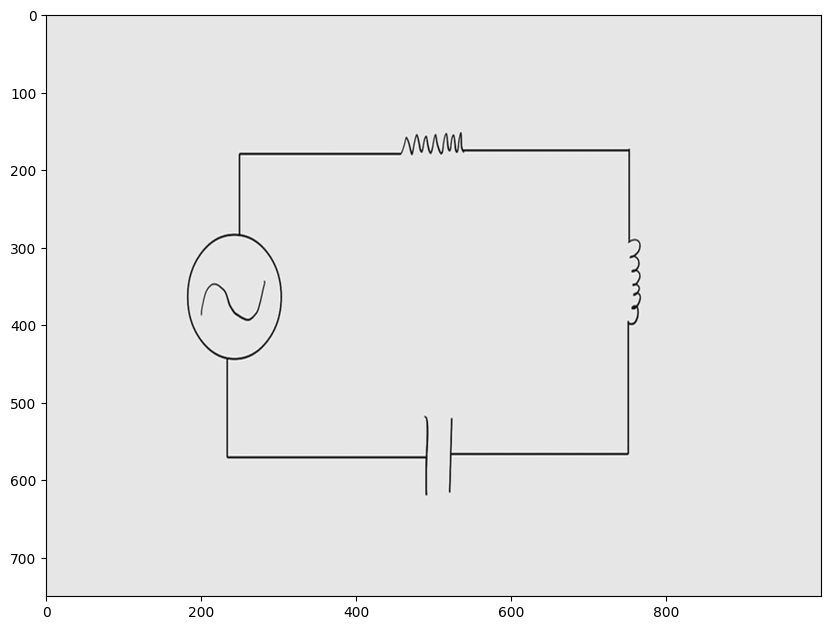

In [15]:
# display sample circuit schematic
img_raw = cv2.imread(os.listdir()[1])
img_raw = cv2.resize(img_raw, (1000, 750), interpolation=4)
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.show()

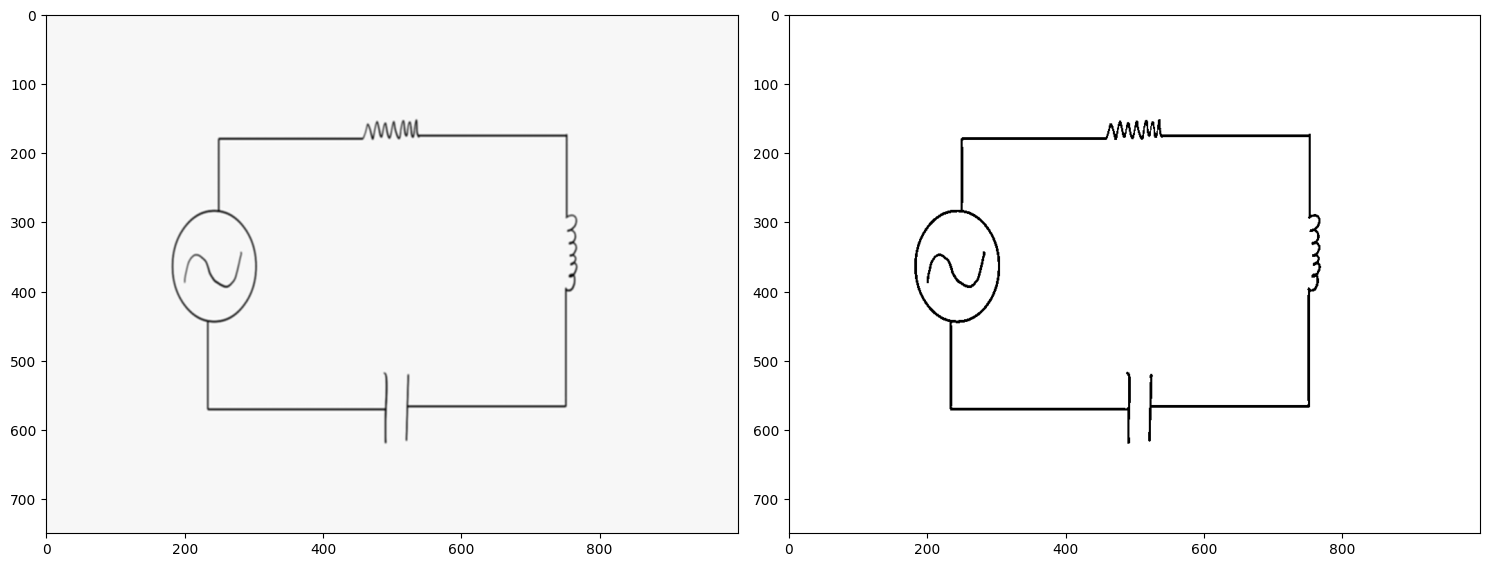

In [16]:
#@title Transformation Parameters { run: "auto" }

BLOCK = 27 #@param {type:"slider", min:1, max:27, step:2}
C = 10 #@param {type:"slider", min:0, max:30, step:1}

img = cv2.GaussianBlur(img,(5,5),0)

imgTres = cv2.adaptiveThreshold(img,255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY
                                ,BLOCK,C)

scale = 15

plt.figure(figsize=(1*scale,2*scale))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(imgTres, cmap='gray')

plt.tight_layout()

(-0.5, 999.5, 749.5, -0.5)

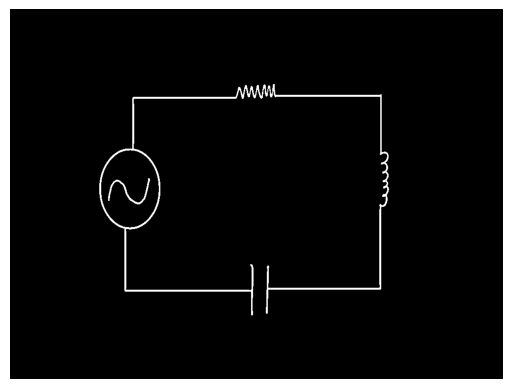

In [22]:
from pprint import pprint
img_tres = cv2.bitwise_not(imgTres)/255

plt.imshow(img_tres, 'gray')
plt.axis('off')

(-0.5, 999.5, 749.5, -0.5)

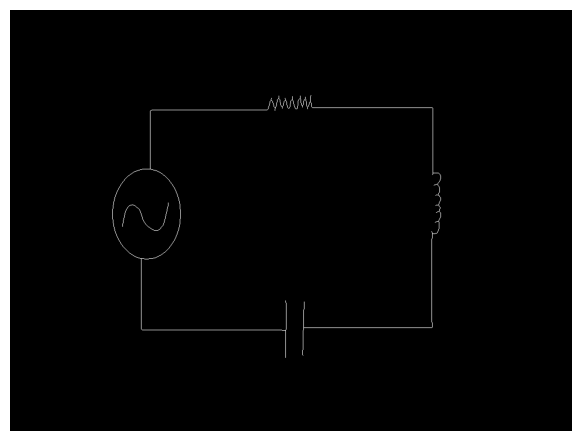

In [23]:
# perform morphological thinning to get 1px stroke

from skimage import io, color, morphology

imgSkel = morphology.skeletonize(img_tres)
imgThin = morphology.thin(imgTres < 0.5)

plt.imshow(imgSkel, cmap='gray')

plt.tight_layout()
plt.axis('off')

(-0.5, 999.5, 749.5, -0.5)

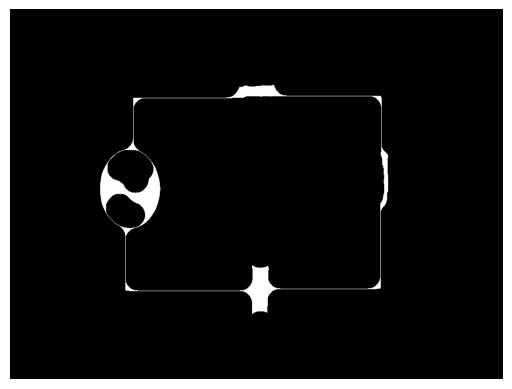

In [24]:
# morphological closing gives blobs around the components

CLOSE_SIZE = 64

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))

imgSkel.dtype = 'uint8'
img_close = cv2.bitwise_not(imgSkel)


img_close = np.copy(imgSkel)
img_close = cv2.morphologyEx(img_close, cv2.MORPH_CLOSE, kernel, iterations=1)

# plt.figure(figsize=FIG_SIZE)
plt.imshow(img_close, cmap='gray')
plt.axis('off')


(-0.5, 999.5, 749.5, -0.5)

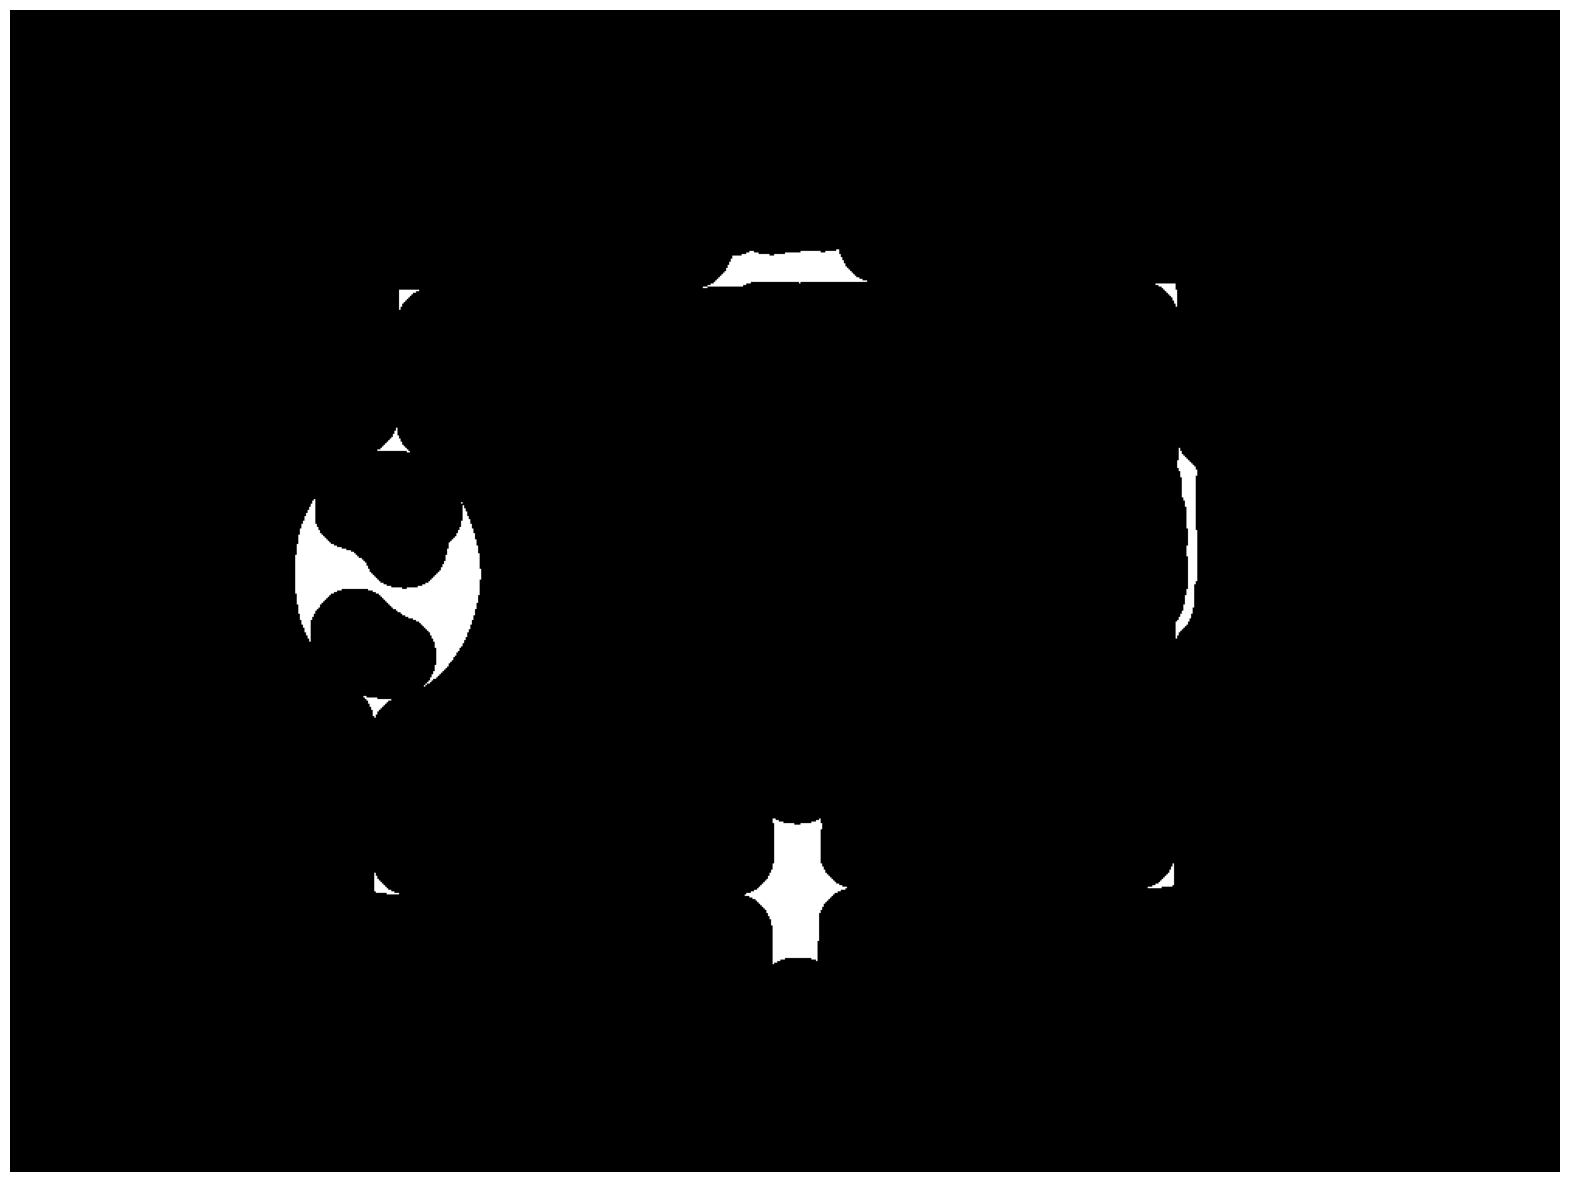

In [25]:
# morphological erosion used to erase connecting lines
# leaving just blobs

kernel = np.ones((3,3),np.uint8)
img_blob = cv2.erode(img_close,kernel,iterations = 1)

plt.figure(figsize=FIG_SIZE)
plt.imshow(img_blob, cmap='gray')
plt.axis("off")


(-0.5, 999.5, 749.5, -0.5)

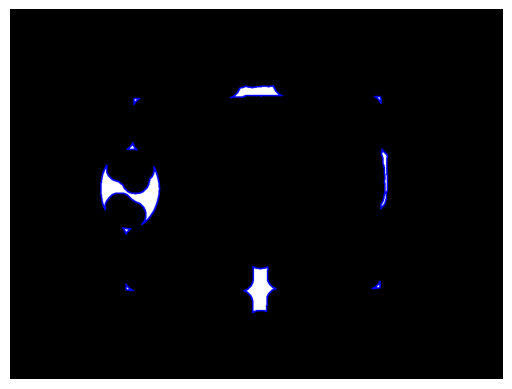

In [26]:
img_cont = img_raw.copy()

# contour detection
contours5, heirachy = cv2.findContours(img_blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_conts = np.zeros_like(img_raw)
img_conts = cv2.drawContours(cv2.cvtColor(img_blob*255, cv2.COLOR_GRAY2BGR), contours5, -1, (0,0,255), 2)

plt.imshow(img_conts)
plt.axis('off')

In [27]:
# draw bounding boxes around detection components (blobs)
# returns tuple of new image with boudning boxes, and component locations

def detect_components(img_raw):

    img_cont = img_raw.copy()

    # contour detection
    contours5, heirachy = cv2.findContours(img_blob, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    components = []

    for c in contours5:
        x, y, w, h = cv2.boundingRect(c)

        # threshold for 50x50 structuring element
        if(w > CLOSE_SIZE or h > CLOSE_SIZE):
            # only include if box meets this threshold
            components.append(np.array((y-10, h+20, x-10, w+20)))

            # rect = cv2.rectangle(img_cont, (x, y), (x + w, y + h), (0,255,0), 3)

    return components

In [28]:

def draw_squares(img_raw):

    img_squares = img_raw.copy()
    components = detect_components(img_squares)
    squares = []

    for i in range(len(components)):
        y,h,x,w = components[i]

        # expanding aspect ratio to square
        if h > w:
            square = (y, y+h, x - h//4, x + 3*h//4) # expand quater on the right,
                                                    # 3/4 on the left of image
        else:
            square = (y - w//4, y + 3*w//4, x, x+w) # expand quater on the bottom,
                                                    # 3/4 on the top of image

        # squares.append(square)
        squares.append(square)
        y,h,x,w = square

        # draw squares on copy of the img_raw
        # cv2.rectangle(img_raw, (x, y), (w, h), (0,255,0), 3)

    return squares

In [29]:
import keras

# deep convolutional neural network
model = keras.models.load_model('C:/Users/Nicollas Fernandes/Documents/Faculdade/IC/Teste_nos_trabalhos_encontrados/circuitnet-master/treinamento1/model.keras')

## here we use the CNN to preduct the component and 
## output the prediction to a json netlist

# return the dict of predictions for the list of components
def predict_objects(img_raw):

    class_names = ['fonte', 'capacitor', 'indutor', 'resistor']
    components = detect_components(img_raw)

    component_objects = {}

    for i in range(len(components)):
        y,h,x,w = components[i]

        # expanding aspect ratio to square
        if h > w:
            square = (y, y+h, x - h//2 + w//2, x + h//2 + w//2) # expand width to size of height
            orientation = "v"
        else:
            square = (y - w//2 + h//2, y + w//2 + h//2, x, x+w) # expand height to size of width
            orientation = "h"

        # expanding aspect ratio to square
        y,h,x,w = square
        crop = img[y:h, x:w]


        img_square = keras.preprocessing.image.img_to_array(crop)

        try:
            img_square = cv2.resize(img_square, (128, 128))
        except:
            continue

        img_square = np.expand_dims(img_square, axis=0)
        img_square = np.vstack([img_square])
        img_square.shape

        prediction = model.predict(img_square)

        # output of softmax -> gives class with highest probaility
        classes = np.argmax(prediction, axis=-1)

        # maps highest probability class with classname
        class_prediction = class_names[int(classes)]

        component_objects.update({i + 1 :
                                    {
                                        'type': class_prediction,
                                        'location' : square,
                                        'orientation': orientation
                                    }
                                  })

    return component_objects

In [22]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 120, 120, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 117, 117, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 54, 54, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 23, 23, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,792,238 (6.84 MB)

 Trainable params: 597,412 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,194,826 (4.56 MB)

In [46]:
# Used to draw bounding boxes and predictions on image
def draw_components(img_raw):

    img = img_raw.copy()

    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    except:
        pass

    components = predict_objects(img)

    FONT_FACE = cv2.FONT_HERSHEY_DUPLEX
    FONT_SCALE = 0.7
    COLOR = (0,0,255)


    for i in components:
        y,h,x,w = components[i]['location']

        img_overlay = np.ones_like(img[y:h,x:w])*255

        # draw bounding-boxes around image
        # cv2.rectangle(img, (x, y), (w, h), COLOR, 2)

        cv2.rectangle(img_overlay, (0, 0), (w, h), (0, 0, 255), -1)
        cv2.rectangle(img, (x, y), (w, h), (0, 0, 255), 2)

        img[y:h,x:w] = cv2.addWeighted(img[y:h,x:w], 1, img_overlay, 0.1, 0)

        # get predicted label for component
        component = components[i]['type']
        orientation = components[i]['orientation']

        # add labels above bounding boxes
        # cv2.putText(img, f'{component},{orientation}', (x, y-12), FONT_FACE, FONT_SCALE, COLOR, 1)
        cv2.putText(img, f'{component}', (x, y-30), FONT_FACE, FONT_SCALE, COLOR, 1)

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\Nicollas Fernandes\AppData\Local\Temp\ipykernel_26228\1544299154.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_prediction = class_names[int(classes)]


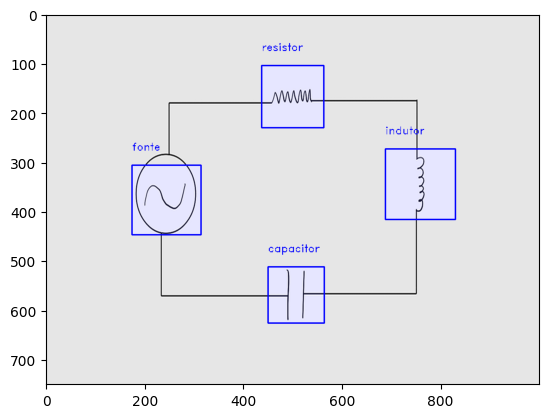

In [47]:
plt.imshow(draw_components(img_raw))

# Circuit Generation

In [25]:
import pprint
cad_components = predict_objects(imgTres)
pprint.pprint(cad_components)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
{1: {'location': (512, 626, 450, 564), 'orientation': 'v', 'type': 'capacitor'},
 2: {'location': (306, 447, 174, 314), 'orientation': 'v', 'type': 'fonte'},
 3: {'location': (273, 416, 688, 830), 'orientation': 'v', 'type': 'indutor'},
 4: {'location': (104, 230, 437, 563), 'orientation': 'h', 'type': 'resistor'}}


C:\Users\Nicollas Fernandes\AppData\Local\Temp\ipykernel_3296\1544299154.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_prediction = class_names[int(classes)]


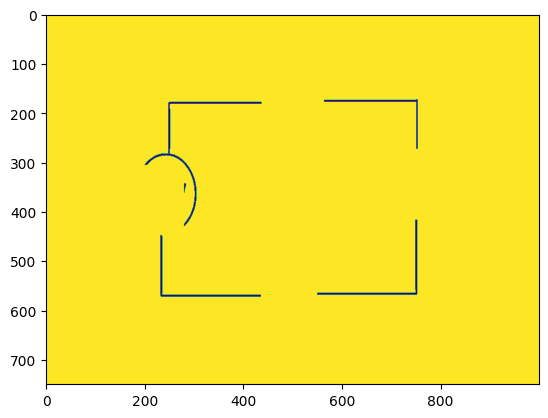

In [30]:
img_nodes = imgTres.copy()

squares = draw_squares(img_nodes)

for square in squares:
    y,h,x,w = square

    cv2.rectangle(img_nodes, (x, y), (w, h), (255,255,255), -1)

# img_nodes = cv2.bilateralFilter(img_nodes,91,75,75)
plt.imshow(img_nodes)


In [31]:
# copy img_node for horizontal
# and vertical lines
img_horiz = img_nodes.copy()
img_vert = img_nodes.copy()

# Specify size on horizontal axis
horizontal_size = vertical_size = 15

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size,1))

# Apply morphology operations
img_horiz = cv2.dilate(img_horiz, horizontalStructure)
img_horiz = cv2.erode(img_horiz, horizontalStructure)


# Show extracted horizontal lines
# cv2_imshow(img_horiz)


In [32]:
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1,vertical_size))

# Apply morphology operations
img_vert = cv2.dilate(img_vert, verticalStructure)
img_vert = cv2.erode(img_vert, verticalStructure)


# Show extracted vertical lines
# cv2_imshow(img_vert)

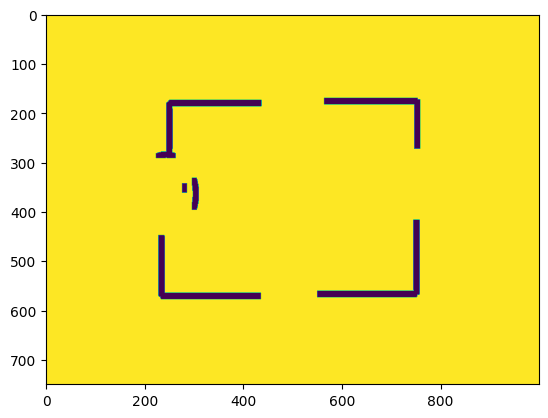

In [34]:
straight_horiz = img_horiz.copy()
straight_vert = img_vert.copy()

# Specify size on horizontal axis
horizontal_size = vertical_size = 10

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1,horizontal_size))
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (vertical_size,1))


# Apply morphology operations
straight_horiz = cv2.erode(straight_horiz, horizontalStructure)

straight_vert = cv2.erode(straight_vert, verticalStructure)


# combone horizontal and vertical components
straight_lines = cv2.bitwise_and(straight_vert,straight_horiz)

plt.imshow(straight_lines)

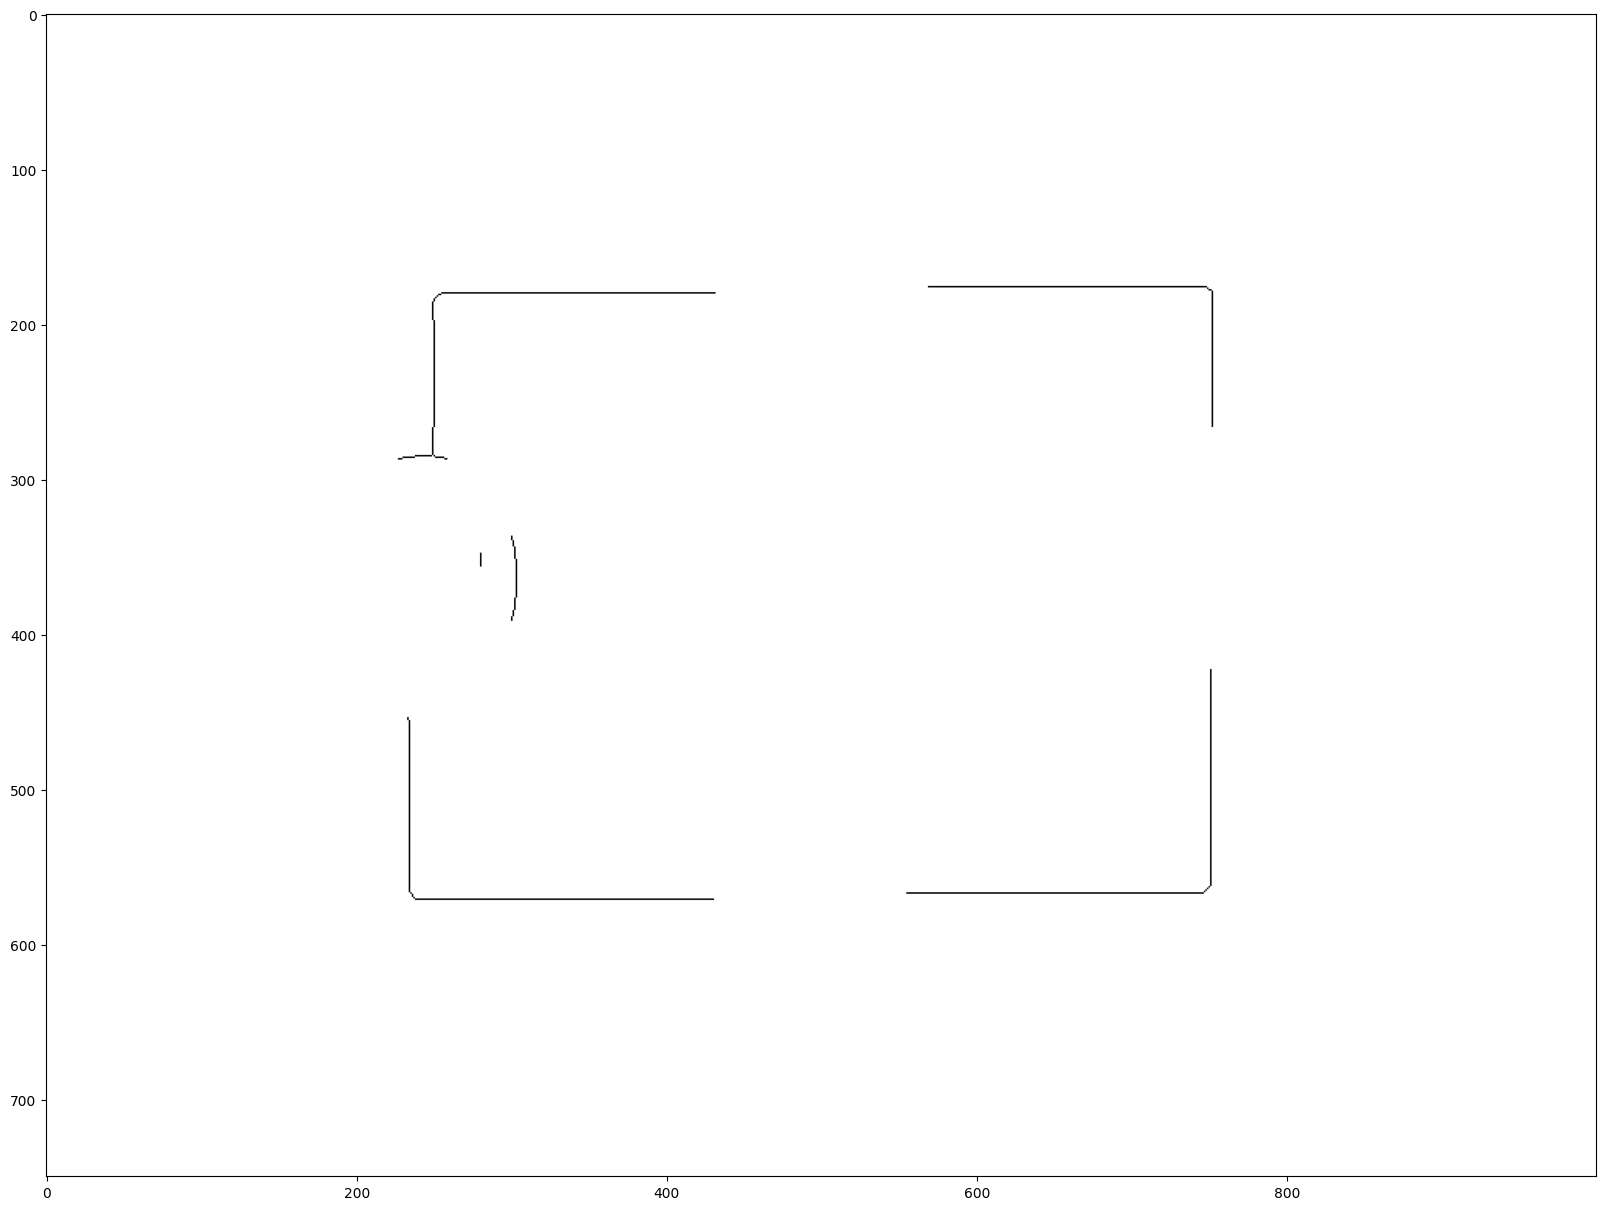

In [35]:
from skimage.morphology import skeletonize

straight_thin = skeletonize(straight_lines < 0.5, method='lee')

plt.figure(figsize=FIG_SIZE)
plt.imshow(straight_thin, cmap="binary")

In [38]:
straight_lines = cv2.bitwise_not(straight_lines)

straight_color = cv2.cvtColor(straight_lines, cv2.COLOR_GRAY2BGR)


lines = cv2.HoughLinesP(straight_lines,
                        rho=6,
                        theta = np.pi / 90,
                        threshold = 160,
                        lines=np.array([]),
                        minLineLength=50,
                        maxLineGap=20)

img_blank = np.zeros_like(straight_color)


for line in lines:
    x, y, w, h = line.T
    cv2.line(img_blank,(x,y),(w,h),(0,255,0), 1)
    
plt.imshow(img_blank)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
